In [1]:
print('Start import')
import socket
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu
import math
from datetime import datetime, timedelta
import cutax

Start import
Working on midway2-0424.rcc.local with the following versions 
and installation paths:
strax
	v1.1.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen
	v1.1.2	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen



In [2]:
#st = cutax.xenonnt_v5(cuts_for=['science_run_0.krypton_selections', 'commissioning.commissioning_cuts'])
st = cutax.contexts.xenonnt_v5(cuts_for=['science_run_0.krypton_selections','base_cuts'])

In [3]:
dsets = st.select_runs(include_tags='_sr0_preliminary', run_mode='*ambe*',available='event_info')

Fetching run info from MongoDB:   0%|          | 0/24595 [00:00<?, ?it/s]

Checking data availability:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dsets = dsets[(dsets.end > pd.to_datetime('06/03/2021'))]

In [5]:
dsets

,name,number,mode,end,source,start,tags,livetime,event_info_available,peak_basics_available,raw_records_available
10289,021463,21463,ambe_link,2021-06-05 07:33:05.423,ambe,2021-06-05 07:31:31.685,_sr0_preliminary,0 days 00:01:33.738000,True,True,False
10291,021461,21461,ambe_link,2021-06-05 07:30:39.007,ambe,2021-06-05 07:20:58.727,_sr0_preliminary,0 days 00:09:40.280000,True,True,False
10293,021459,21459,ambe_link,2021-06-05 07:20:13.491,ambe,2021-06-05 07:17:59.913,"_sr0_preliminary,ambe_source_top_ccw5d0m",0 days 00:02:13.578000,True,True,False
10295,021457,21457,ambe_link,2021-06-05 07:17:39.811,ambe,2021-06-05 06:47:38.474,"_sr0_preliminary,ambe_source_top_ccw5d0m",0 days 00:30:01.337000,True,True,False
10297,021455,21455,ambe_link,2021-06-05 06:47:22.111,ambe,2021-06-05 06:17:20.828,"_sr0_preliminary,ambe_source_top_ccw5d0m",0 days 00:30:01.283000,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
10537,021215,21215,tpc_ambe,2021-06-03 02:24:50.634,ambe,2021-06-03 01:54:49.424,"_sr0_preliminary,ambe_source_top_cw3d0",0 days 00:30:01.210000,True,True,False
10540,021212,21212,tpc_ambe,2021-06-03 01:54:03.587,ambe,2021-06-03 01:24:02.907,"_sr0_preliminary,ambe_source_top_cw3d0",0 days 00:30:00.680000,True,True,False
10543,021209,21209,tpc_ambe,2021-06-03 01:23:34.961,ambe,2021-06-03 00:53:34.823,"_sr0_preliminary,ambe_source_top_cw3d0",0 days 00:30:00.138000,True,True,False
10546,021206,21206,tpc_ambe,2021-06-03 00:52:59.823,ambe,2021-06-03 00:22:59.717,"_sr0_preliminary,ambe_source_top_cw3d0",0 days 00:30:00.106000,True,True,False


In [6]:
runs = np.array(dsets['name'])

In [ ]:
ev = wcu.merge_runs_cutax(st,runs)

In [ ]:
#ev.to_pickle('data/SR0_v5_AmBe_21203_21463_datasets.pkl')

In [8]:
evAB = pd.read_pickle('/dali/lgrandi/dandrea/data/SR0_v4_AmBe_21286_21463_datasets.pkl')
evRn = pd.read_pickle('/dali/lgrandi/dandrea/data/SR0_v4_Rn220_21918_24075_datasets.pkl')
evKr = pd.read_pickle('/dali/lgrandi/dandrea/data/SR0_v4_Kr83m_20210802_datasets.pkl')
#evRn = pd.read_pickle('/dali/lgrandi/dandrea/data/SR0_v5_Rn220_22225_23991_datasets.pkl')
evABall, evABnw, evABfw = wcu.cutevents_wires(evAB)
evRnall, evRnnw, evRnfw = wcu.cutevents_wires(evRn)
evKrall, evKrnw, evKrfw = wcu.cutevents_wires(evKr)
evABallFV, evABnwFV, evABfwFV = wcu.cutevents_wires(evAB,FV=1)
evRnallFV, evRnnwFV, evRnfwFV = wcu.cutevents_wires(evRn,FV=1)
evKrallFV, evKrnwFV, evKrfwFV = wcu.cutevents_wires(evKr,FV=1)

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Total events 233766
Cut with new cut: survived events 124311 -> 53.18%


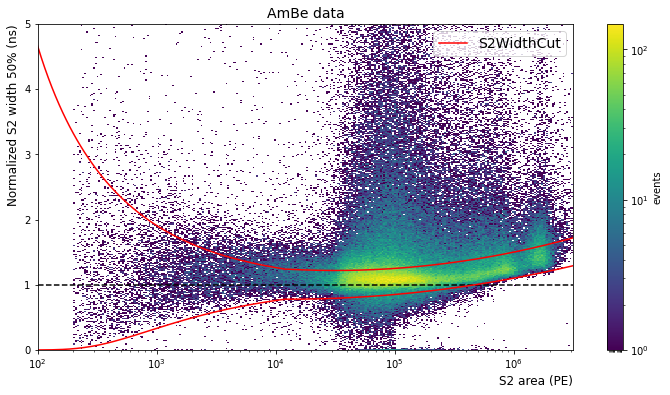

In [9]:
S2WidthCutAB = wcu.S2WidthCut(evABfw,'AmBe data', wrange = (0,5), pll=(0.85, 1.1), phh=(1.25, 1.5),plot = 1)

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Total events 1051269
Cut with new cut: survived events 452542 -> 43.05%


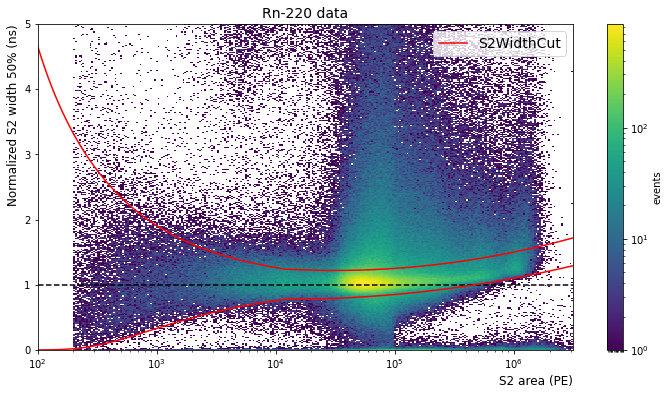

In [10]:
S2WidthCutRn = wcu.S2WidthCut(evRnfw,'Rn-220 data', wrange = (0,5),pll=(0.85, 1.1), phh=(1.25, 1.5), plot = 1 )

Total events 33687
Cut with new cut: survived events 21519 -> 63.88%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:260: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(aa0,nc/cc,c='r',ds='steps',label='S2WidthCut')


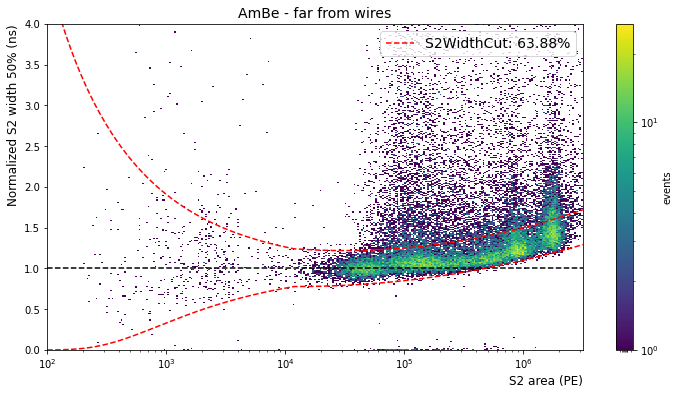

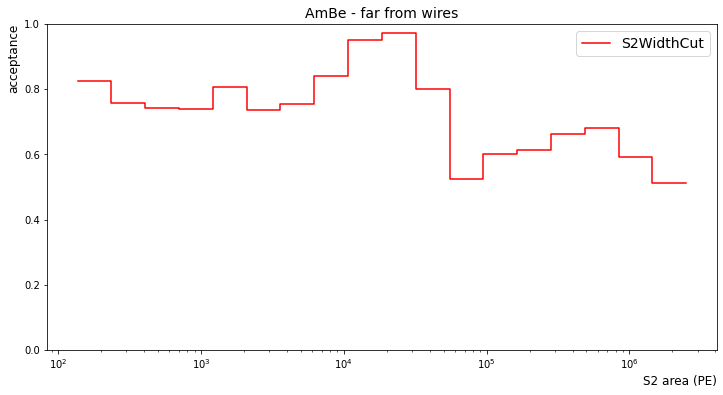

In [11]:
wcu.S2WidthCut_plot(evABfwFV, 'AmBe - far from wires', cut=S2WidthCutRn, wrange = (0,4),bins=20)

Total events 5512
Cut with new cut: survived events 2727 -> 49.47%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:260: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(aa0,nc/cc,c='r',ds='steps',label='S2WidthCut')


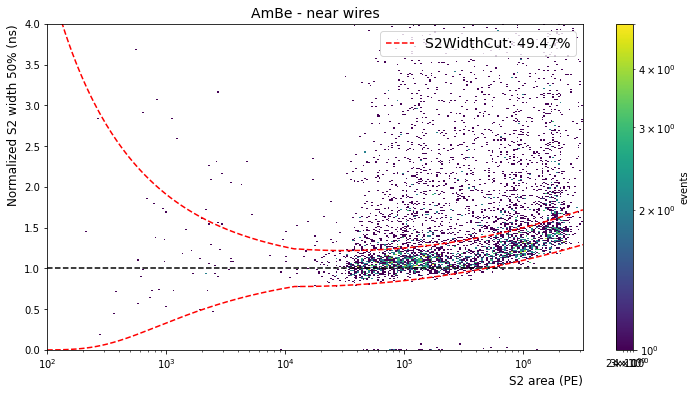

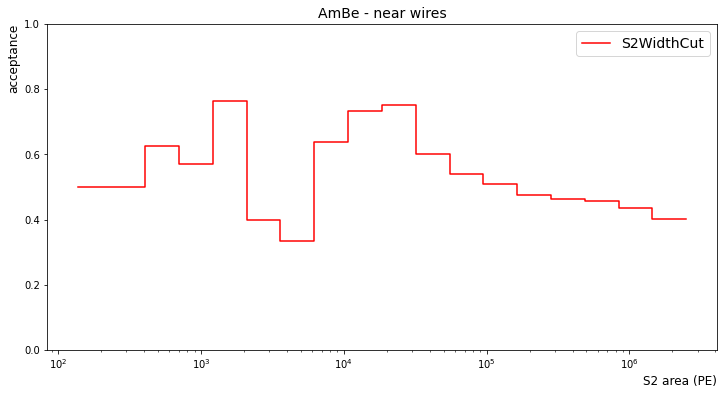

In [12]:
wcu.S2WidthCut_plot(evABnwFV, 'AmBe - near wires', cut=S2WidthCutRn, wrange = (0,4),bins=20)

Total events 198852
Cut with new cut: survived events 150420 -> 75.64%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:260: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(aa0,nc/cc,c='r',ds='steps',label='S2WidthCut')


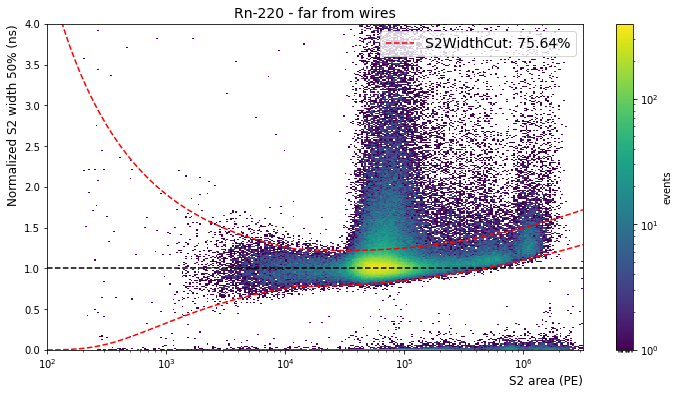

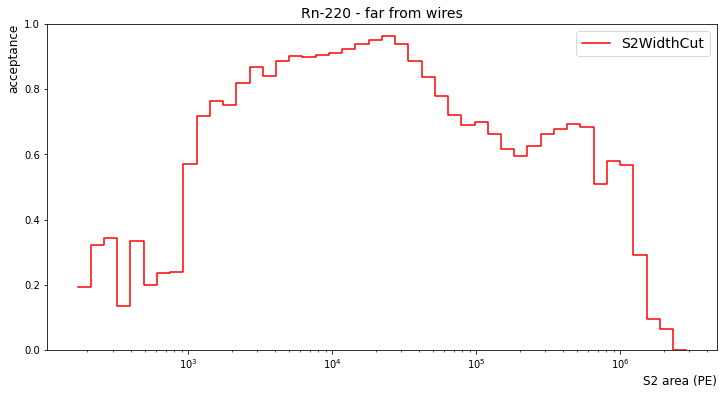

In [13]:
wcu.S2WidthCut_plot(evRnfwFV, 'Rn-220 - far from wires', cut=S2WidthCutRn, wrange = (0,4),bins=50)

Total events 29386
Cut with new cut: survived events 18079 -> 61.52%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:260: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(aa0,nc/cc,c='r',ds='steps',label='S2WidthCut')


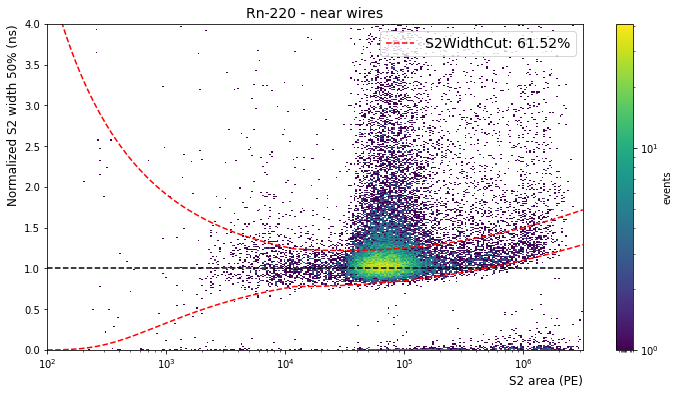

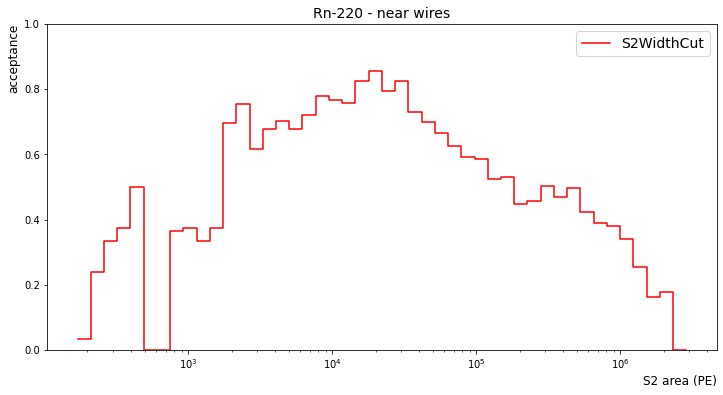

In [14]:
wcu.S2WidthCut_plot(evRnnwFV,'Rn-220 - near wires',cut=S2WidthCutRn,wrange=(0,4),bins=50)

Total events 72027
Cut with new cut: survived events 53836 -> 74.74%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:260: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(aa0,nc/cc,c='r',ds='steps',label='S2WidthCut')


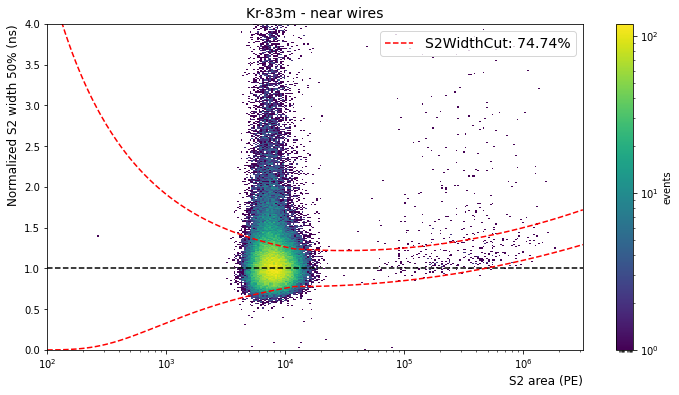

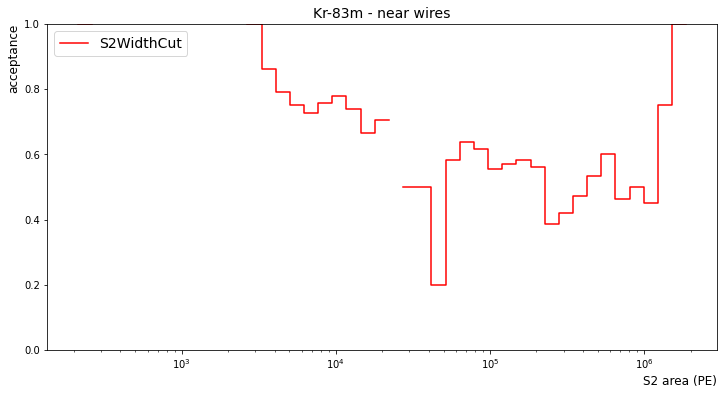

In [15]:
wcu.S2WidthCut_plot(evKrnwFV,'Kr-83m - near wires',cut=S2WidthCutRn,wrange=(0,4),bins=50)

Total events 408203
Cut with new cut: survived events 381559 -> 93.47%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:260: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(aa0,nc/cc,c='r',ds='steps',label='S2WidthCut')


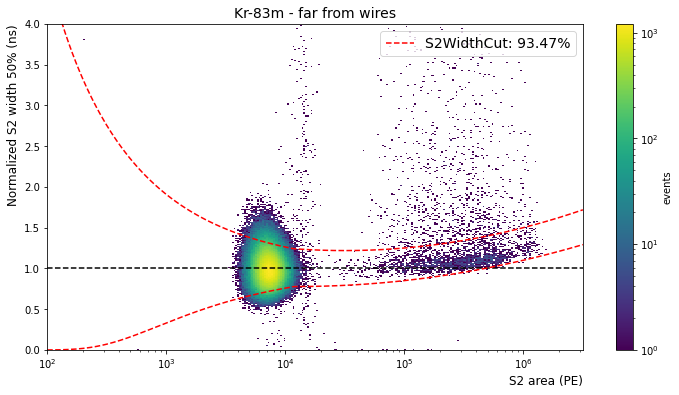

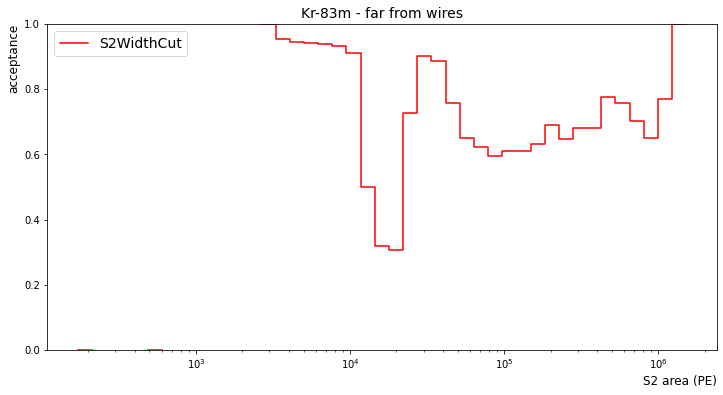

In [16]:
wcu.S2WidthCut_plot(evKrfwFV,'Kr-83m - far from wires',cut=S2WidthCutRn,wrange=(0,4),bins=50)

In [22]:
import pickle
with open('S2WidthCutLow.pkl', 'wb') as f:
    pickle.dump(S2WidthCutRn[1], f)
with open('S2WidthCutHigh.pkl', 'wb') as f:
    pickle.dump(S2WidthCutRn[2], f)

# Plot of S2Width vs drift time and S2Width vs rotate X

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


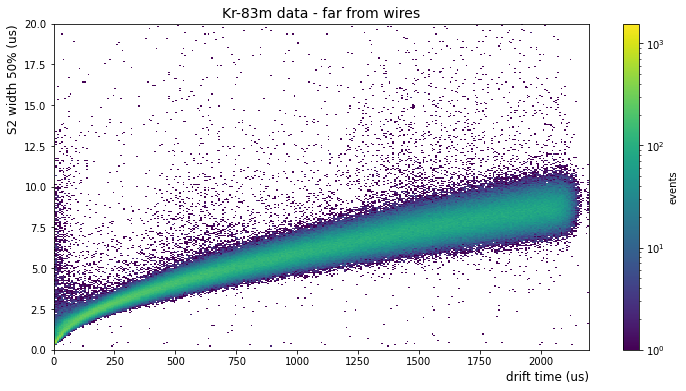

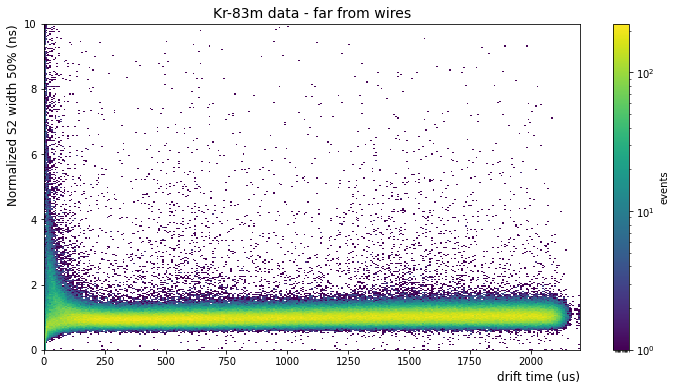

In [17]:
wcu.S2Width_vs_drift(evKrfw, 'Kr-83m data - far from wires')

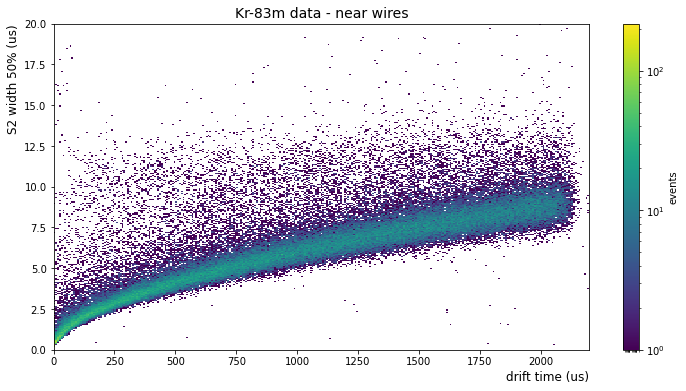

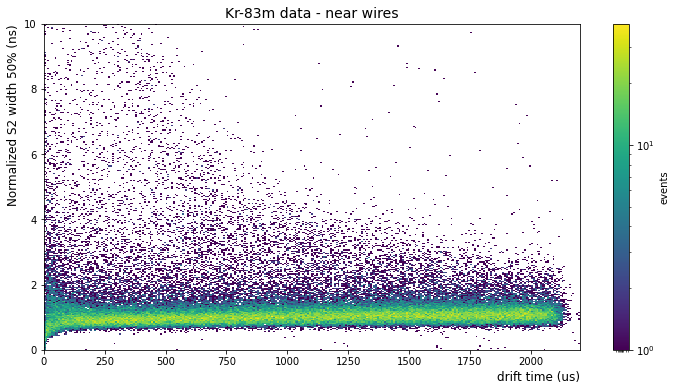

In [18]:
wcu.S2Width_vs_drift(evKrnw, 'Kr-83m data - near wires')

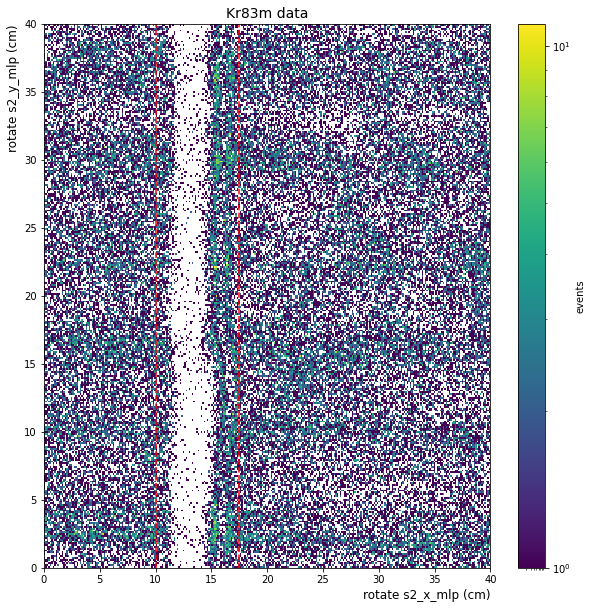

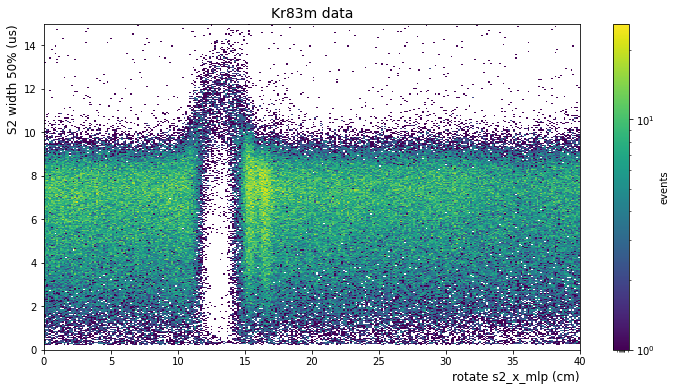

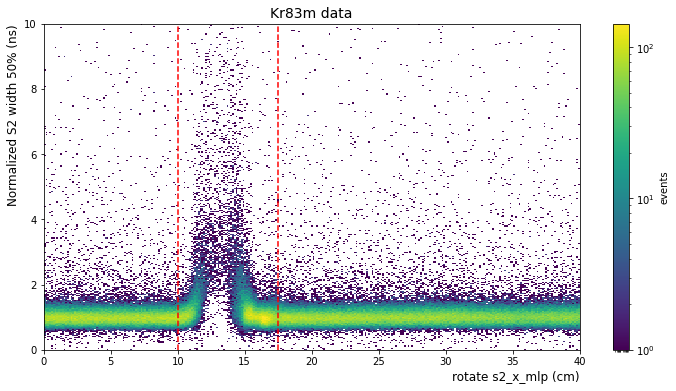

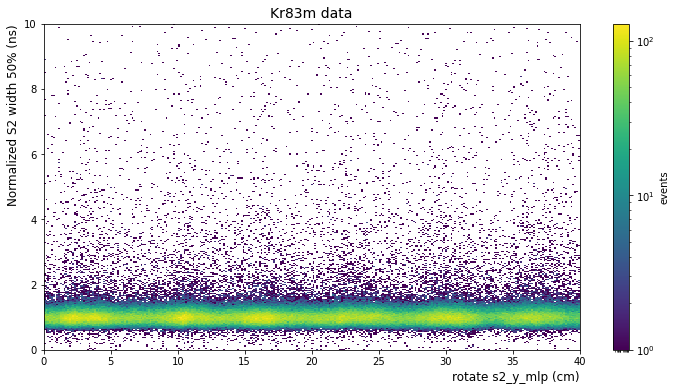

In [19]:
a,b=wcu.mask_S2Width_vs_pos(evKrall, title = 'Kr83m data', xrange = (0,40), plot=1)

# Energy Calibration

total events 233766
total events 124311


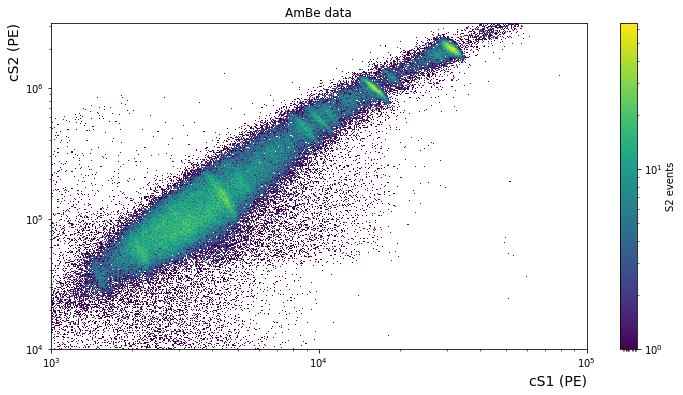

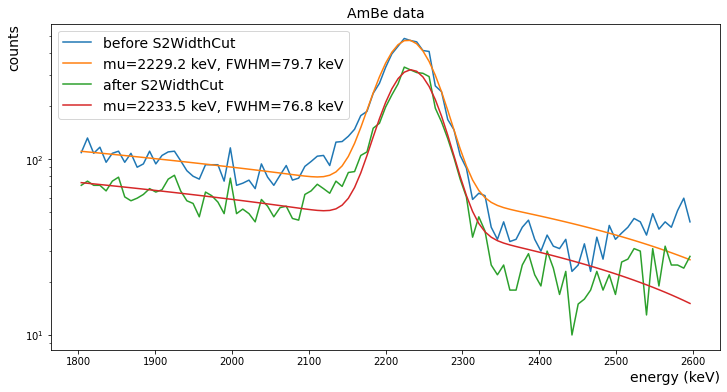

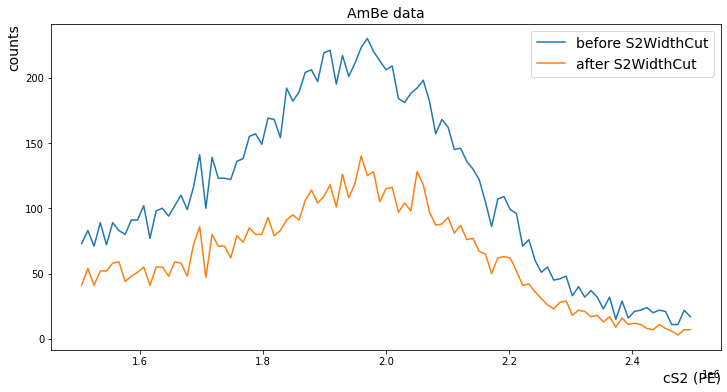

In [20]:
cut = S2WidthCutAB[0]
wcu.plot_cs1_cs2(evABfw,evABfw[cut], 'AmBe data',low=1.8e3,high=2.6e3,low2 = 1.5e6, high2 = 2.5e6,
             bins=100,guess=(300,2225,100,20,1))

total events 233766
total events 124311


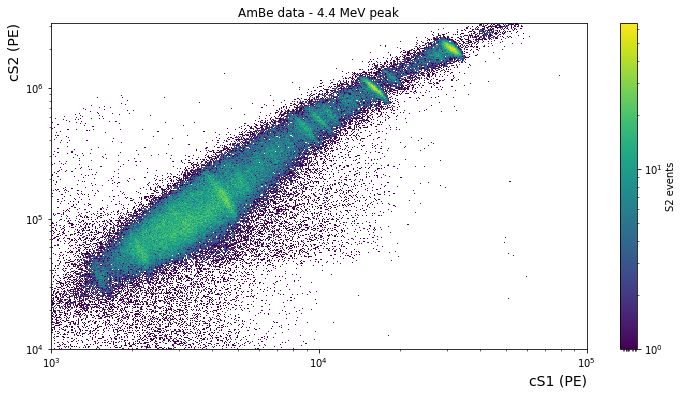

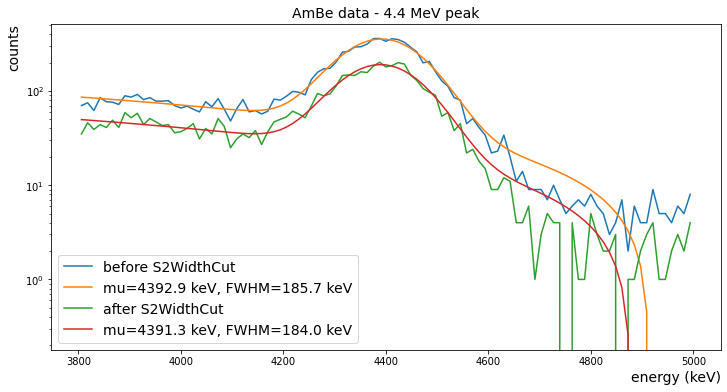

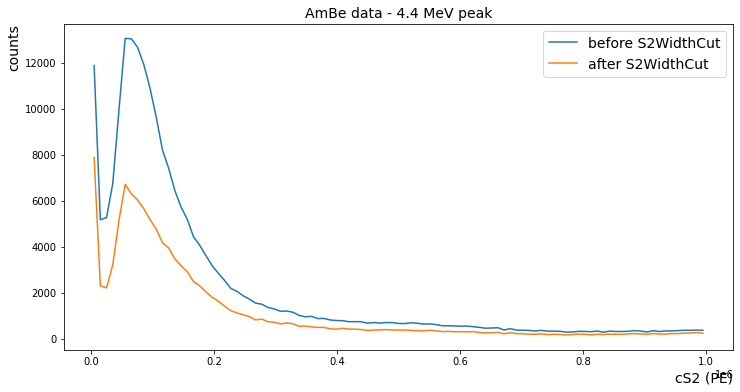

In [21]:
wcu.plot_cs1_cs2(evABfw,evABfw[cut], 'AmBe data - 4.4 MeV peak',low=3.8e3,high=5.0e3,
             bins=100,guess=(300,4400,100,20,1))

# Display Events

In [8]:
import bokeh.plotting as bklt
from IPython.core.display import display, HTML
def display_events_S2WidthCut(st,run_id, nev = 1, area_cut=(1e2,1e7), s2_width_cut = None,
                              mod_par = (44.04,0.673,3.2), selection = 0):
    if (st.is_stored(run_id, ('event_info'))==False): return print('No events stored')
    ev0 = st.get_array(run_id,['event_info', 'cut_s1_max_pmt',
                            'cut_s1_area_fraction_top',
                            'cut_s2_single_scatter',
                            'cut_s2_width_naive',
                            'cut_fiducial_volume',
                            'cut_daq_veto'],progress_bar=False)
    ev, evnr, evfw = wcu.cutevents_wires(ev0,FV=1)
    events = ev[(ev['s2_area'] > area_cut[0]) & (ev['s2_area'] < area_cut[1])]
     
    if s2_width_cut is not None:
        low_cut, high_cut  = s2_width_cut[1], s2_width_cut[2]
        D_mod = mod_par[0]*1e3 * units.cm**2 / units.s
        vd_mod = mod_par[1] * units.mm / units.us
        tG_mod = mod_par[2] * units.ns
        normWidth = s2_width_norm(events['s2_range_50p_area'],s2_width_model(events['drift_time']/1e3,D_mod, vd_mod, tG_mod))
        width_cut = normWidth < high_cut(events['s2_area'])
        width_cut &= normWidth > low_cut(events['s2_area'])
        ev_sel = events[width_cut]
        ev_low = events[normWidth < low_cut(events['s2_area'])]
        ev_high = events[normWidth > high_cut(events['s2_area'])]
        print('events before width cut',len(events))
        print('events after selection',len(ev_sel))
        print('events with low width',len(ev_low))
        print('events with high width',len(ev_high))
        if selection == 0: events = ev_sel
        elif selection == 1: events = ev_low
        elif selection == 2: events = ev_high
    for i in range(nev):
        idx = int(np.random.rand()*len(events))
        fig = st.event_display_interactive(run_id,
                                           time_range=(events[idx]['time'],
                                                       events[idx]['endtime']),
                                           bottom_pmt_array=False)
        bklt.show(fig)

In [ ]:
display_events_S2WidthCut(st,'024072', nev = 1,area_cut=(5e4,1e5),s2_width_cut = S2WidthCutRn,selection = 1)

2021-10-30 11:35:59.475766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2021-10-30 11:35:59.475814: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2021-10-30 11:36:04.978348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/XENONnT/anaconda/envs/XENONnT_development/lib64:/opt/XENONnT/anaconda/envs/XENONnT_development/lib:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib:/opt/rh/devtoolset-9/root/usr/lib64/dyninst:/opt/rh/devtoolset-9/root/usr/lib/dyninst:/opt/rh/devtoolset-9/root/usr/lib64:/opt/rh/devtoolset-9/root/usr/lib
2021-10-30 11:36:04.978383: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-30 11:36:04.978404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (midway2-0415.rcc.local): /proc/driver/nvidia/version does not exist
2021-10-30 11:36:04.978634: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFl

In [ ]:
from local_minimum_info import LocalMinimumInfo
st.register(LocalMinimumInfo)
loc_min = st.get_array('022225',['event_info','local_min_info'])